## Graduate Empoyability Predictor - By: Anish, David, Rahul, Sean and Timur

### Introduction

This project investigates and compares three distinct machine learning models, Logistic Regression, Decision Trees, and Neural Neworks for predicting employability. By evaluating their performance metrics (e.g., accuracy, precision, recall), we aim to identify the most effective and robust model for this specific classification task.

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, precision_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [28]:
try:
    df = pd.read_csv('CollegePlacement.csv')
except FileNotFoundError:
    print("Error: collegeplacement.csv not found. Please make sure the file is uploaded to the /content/ directory or specify the correct path.")

## Exploratory Data Description & Analysis

Before training the model we inspect the dataset to understand distributions, class balance, and feature relationships.

Dataset shape: (10000, 10)


,IQ,Prev_Sem_Result,CGPA,Academic_Performance,Extra_Curricular_Score,Communication_Skills,Projects_Completed
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,99.471800,7.535673,7.532379,5.546400,4.970900,5.561800,2.513400
std,15.053101,1.447519,1.470141,2.873477,3.160103,2.900866,1.715959
min,41.000000,5.000000,4.540000,1.000000,0.000000,1.000000,0.000000
25%,89.000000,6.290000,6.290000,3.000000,2.000000,3.000000,1.000000
50%,99.000000,7.560000,7.550000,6.000000,5.000000,6.000000,3.000000
75%,110.000000,8.790000,8.770000,8.000000,8.000000,8.000000,4.000000
max,158.000000,10.000000,10.460000,10.000000,10.000000,10.000000,5.000000


,College_ID,Internship_Experience,Placement
count,10000,10000,10000
unique,100,2,2
top,CLG0062,No,No
freq,133,6036,8341



Missing values per column:
College_ID                0
IQ                        0
Prev_Sem_Result           0
CGPA                      0
Academic_Performance      0
Internship_Experience     0
Extra_Curricular_Score    0
Communication_Skills      0
Projects_Completed        0
Placement                 0
dtype: int64

Placement distribution (count / percent):
           count  percent
Placement                
No          8341    83.41
Yes         1659    16.59


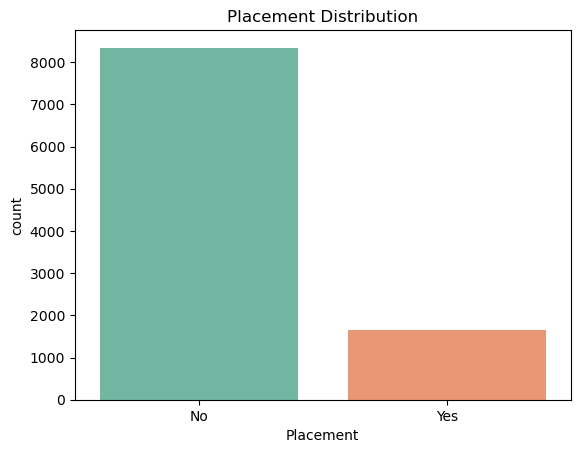

In [29]:
print(f"Dataset shape: {df.shape}")
display(df.describe())
display(df.describe(include="object"))

print("\nMissing values per column:")
print(df.isna().sum())

placement_counts = df['Placement'].value_counts()
placement_pct = (placement_counts / len(df) * 100).round(2)
print("\nPlacement distribution (count / percent):")
print(pd.concat([placement_counts, placement_pct], axis=1, keys=['count', 'percent']))

sns.countplot(data=df, x='Placement', palette='Set2', hue='Placement')
plt.title('Placement Distribution')
plt.show()

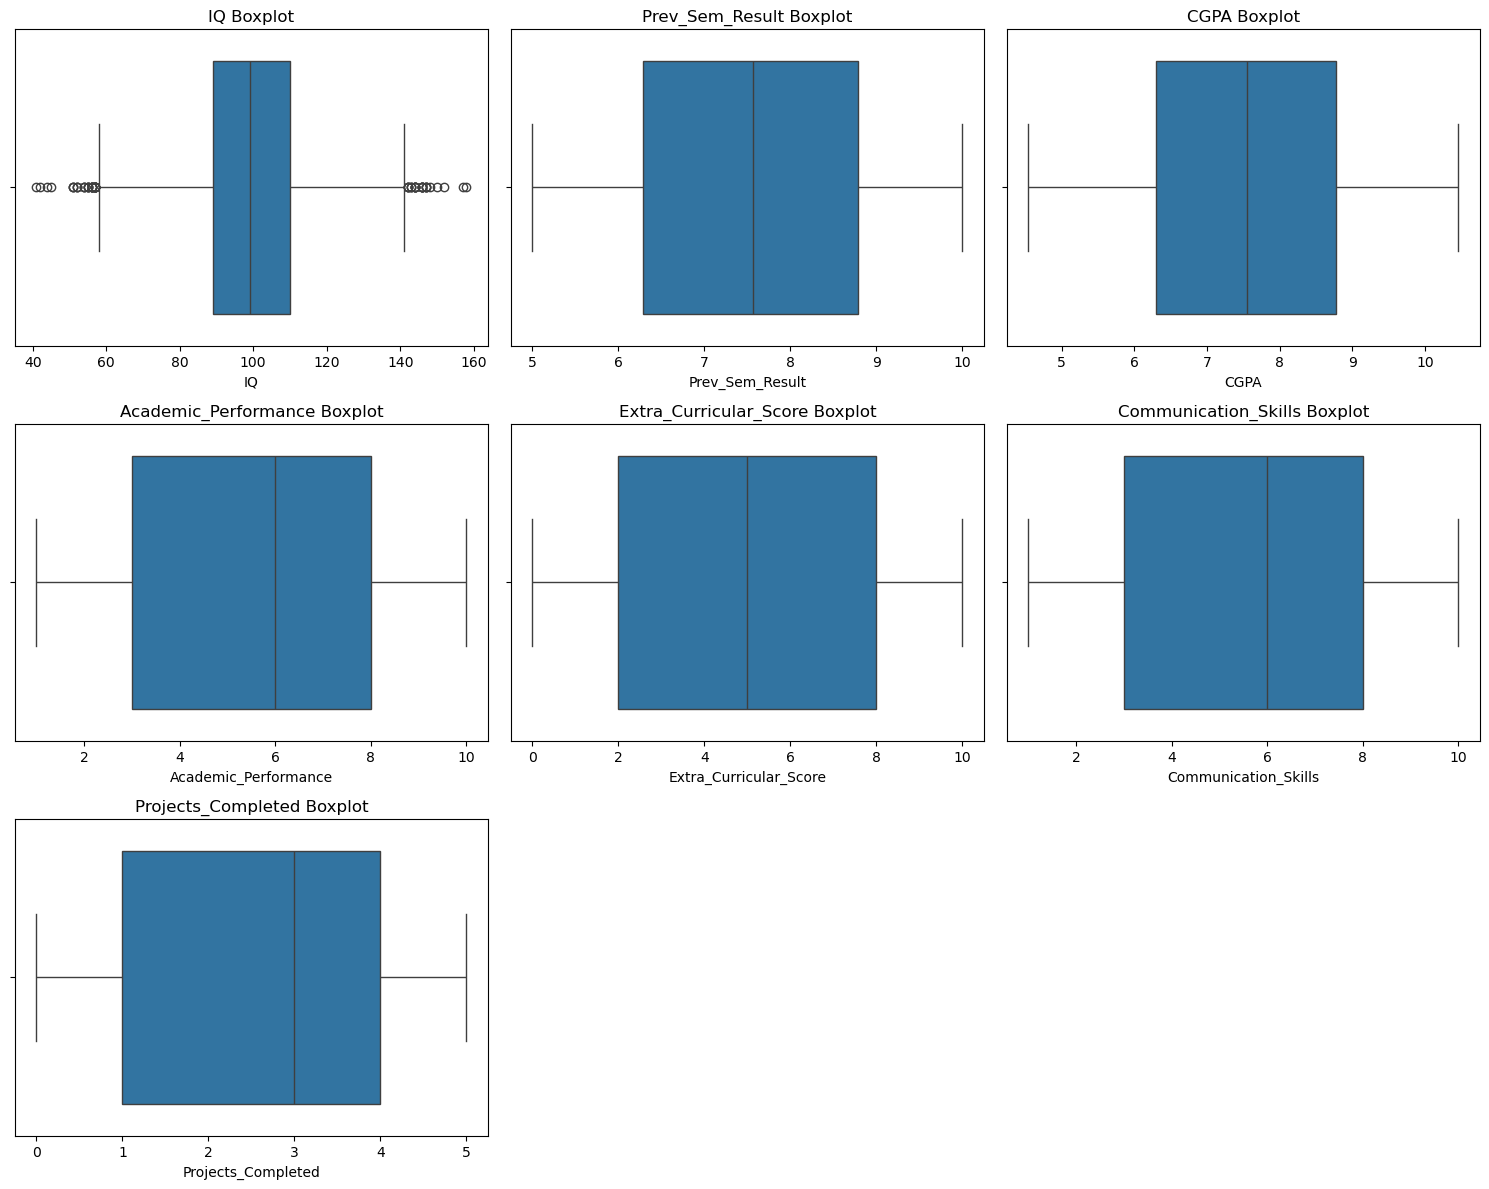

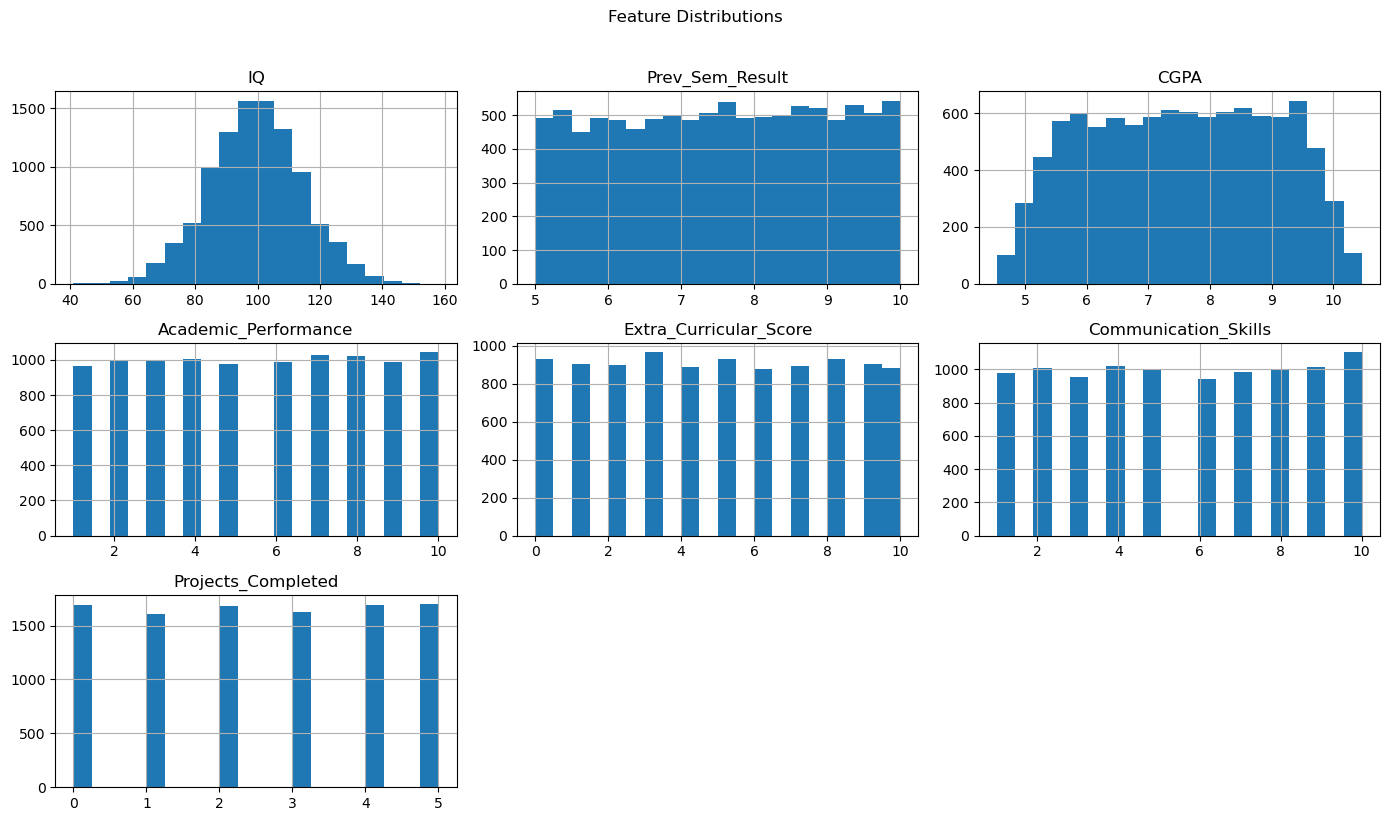

In [30]:
numeric_cols = ['IQ', 'Prev_Sem_Result', 'CGPA', 'Academic_Performance',
                'Extra_Curricular_Score', 'Communication_Skills', 'Projects_Completed']

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()
for ax, col in zip(axes, numeric_cols):
    sns.boxplot(x=df[col], ax=ax)
    ax.set_title(f'{col} Boxplot')
for ax in axes[len(numeric_cols):]:
    ax.axis('off')
plt.tight_layout()
plt.show()

df[numeric_cols].hist(bins=20, figsize=(14, 8))
plt.suptitle('Feature Distributions', y=1.02)
plt.tight_layout()
plt.show()

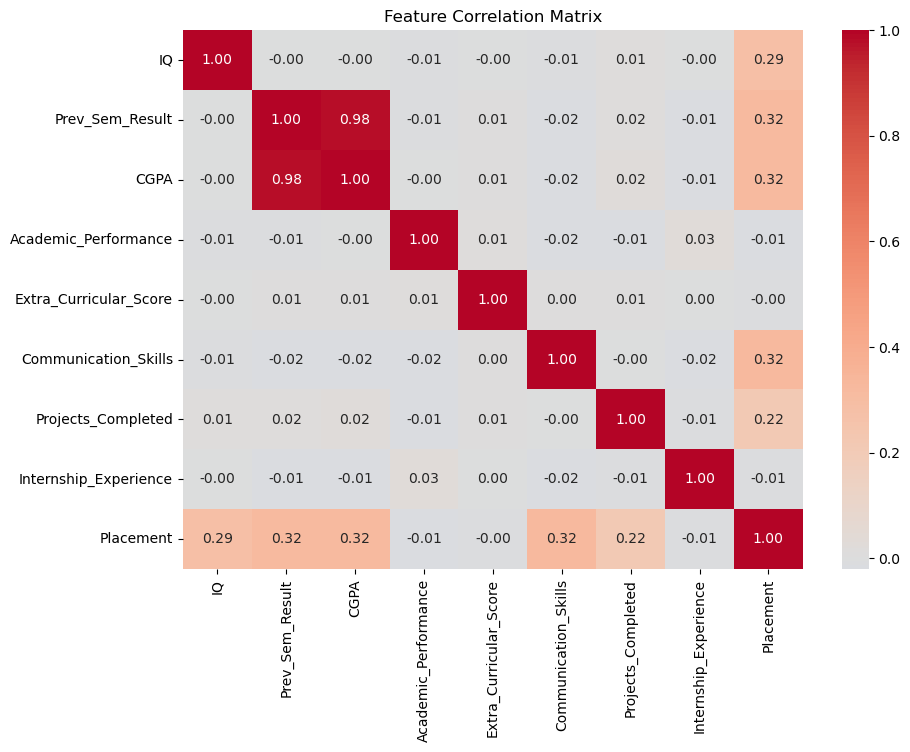

In [31]:
corr_df = df.copy()
corr_df['Internship_Experience'] = corr_df['Internship_Experience'].map({'Yes': 1, 'No': 0})
corr_df['Placement'] = corr_df['Placement'].map({'Yes': 1, 'No': 0})

corr_cols = numeric_cols + ['Internship_Experience', 'Placement']
corr = corr_df[corr_cols].corr()

plt.figure(figsize=(10, 7))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

## Preprocessing Data

This step involves several data preprocessing tasks: dropping the 'College_ID' column as it's irrelevant, encoding 'Internship Experience' and 'Placement' from 'Yes'/'No' to numerical '1'/'0' values, and then scaling all features using `StandardScaler`. Finally, the dataset will be split into training (80%) and testing (20%) sets.


In [32]:
# 1. Remove the 'College_ID' column
df = df.drop('College_ID', axis=1)
print("Dropped 'College_ID' column.")

# 2. Convert 'Internship Experience' and 'Placement' to numerical values
df['Internship_Experience'] = df['Internship_Experience'].map({'Yes': 1, 'No': 0})
df['Placement'] = df['Placement'].map({'Yes': 1, 'No': 0})
print("Encoded 'Internship Experience' and 'Placement' columns.")

# 3. Separate features (X) and target (y)
X = df.drop('Placement', axis=1)
y = df['Placement']
print("Separated features (X) and target (y).")

# 4. Split into training and testing before scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Split data into training (80%) and testing (20%) sets.")

# 5. StandardScalar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. Back to data frame for handling
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)
print("Scaled features using StandardScaler.")

print("\nShape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Dropped 'College_ID' column.
Encoded 'Internship Experience' and 'Placement' columns.
Separated features (X) and target (y).
Split data into training (80%) and testing (20%) sets.
Scaled features using StandardScaler.

Shape of X_train: (8000, 8)
Shape of X_test: (2000, 8)
Shape of y_train: (8000,)
Shape of y_test: (2000,)


## Logisitc Regression Implementation

In [33]:
model = LogisticRegression(random_state=42)

# Train the model using the training data
model.fit(X_train, y_train)

print("Logistic Regression model trained successfully.")

Logistic Regression model trained successfully.


In [34]:
# 1. Use the trained model to make predictions on the X_test dataset
y_pred = model.predict(X_test)
print("Predictions made on the test set.")

# 2. Calculate the accuracy, recall, and F1-score of the model
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Logistic Regression Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# 3. Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"\nConfusion Matrix:\n{conf_matrix}")

Predictions made on the test set.
Logistic Regression Performance Metrics:
Accuracy: 0.9035
Recall: 0.6074
F1-Score: 0.6723

Confusion Matrix:
[[1609   65]
 [ 128  198]]


## Logisitic Regression Performance Metrics:

### Data Analysis Key Findings

*   **Data Preparation**:
    *   The `College_ID` column was removed, and the categorical fields `Internship_Experience` and `Placement` were successfully converted from Yes/No to 1/0.
    *   All features were scaled using `StandardScaler` to brig them onta a consistent range.
    *   The dataset was then split into an 80 percent training set and a 20 percent testing set, giving `X_train` with 8000 samples and `X_test` with 2000 samples.
*   **Model Training**: A Logistic Regression model was created and trained on the processed training data without any issues.
*   **Model Evaluation**: The model’s performance on the test set produced the following results:
    *   **Accuracy**: 0.9035, showing that the model correctly predicted 90.35 percent of cases.
    *   **Recall**: 0.6074, indicating that it correctly captured about 60 percent of the students who were actually placed.
    *   **F1-Score**: 0.6723, which summarizes the balance between precision and recall.
    *   **Confusion Matrix**:
        *   True Negatives (correctly predicted no placement): 1609
        *   False Positives (incorrectly predicted placement): 65
        *   False Negatives (incorrectly predicted no placement when there was one): 128
        *   True Positives (correctly predicted placement): 198

### Insights

*   The model reaches strong accuracy but has lower recall, which means it tends to miss some students who were actually placed. Examining the false negatives or testing other classification methods could help improve recall.


## Neural Network Implementation

Following the methodology from Assignment 2, we will now implement a Feedforward Neural Network using PyTorch to solve this binary classification problem. We will then compare its performance with the Logistic Regression model.

### 1. Prepare Data for PyTorch
Convert the pandas DataFrames/Series to PyTorch tensors. We must ensure they are floats (`float32`).

In [35]:
# Convert to tensors
X_train_t = torch.tensor(X_train.values, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_t = torch.tensor(X_test.values, dtype=torch.float32)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Create DataLoader
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=32, shuffle=True)

### 2. Define the Neural Network Model
We define a simple feedforward network with two hidden layers, similar to the architecture used in Assignment 2.

In [36]:
class EmployabilityNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

# Initialize model
nn_model = EmployabilityNet(X_train.shape[1]).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-3)

### 3. Training Loop
Train the model for 50 epochs, tracking loss and accuracy.

In [37]:
num_epochs = 50
train_losses, train_accs = [], []

for epoch in range(num_epochs):
    nn_model.train()
    total_loss, total_correct, total = 0, 0, 0
    
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        logits = nn_model(xb)
        loss = criterion(logits, yb)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Stats
        total_loss += loss.item() * xb.size(0)
        preds = (torch.sigmoid(logits) > 0.5).float()
        total_correct += (preds == yb).sum().item()
        total += xb.size(0)

    train_loss = total_loss / total
    train_acc = total_correct / total
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f}")

Epoch 10/50: train_loss=0.0815, train_acc=0.9709
Epoch 20/50: train_loss=0.0363, train_acc=0.9888
Epoch 30/50: train_loss=0.0191, train_acc=0.9946
Epoch 40/50: train_loss=0.0118, train_acc=0.9964
Epoch 50/50: train_loss=0.0086, train_acc=0.9969


### 4. Visualize Training Performance
Plotting the training loss and accuracy to verify convergence.

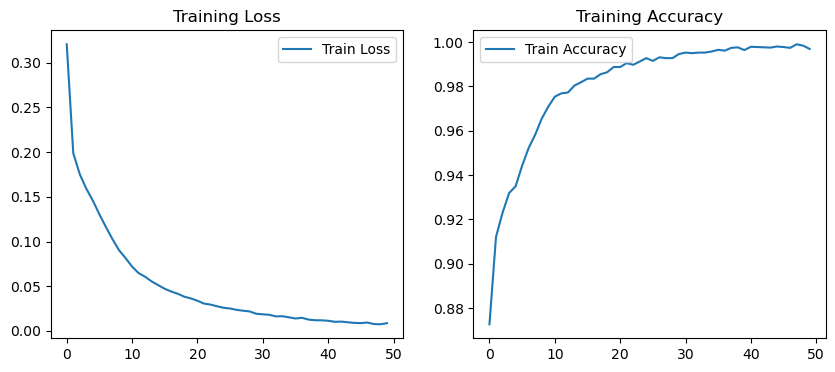

In [38]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

### 5. Evaluate Neural Network on Test Set

In [39]:
nn_model.eval()
with torch.no_grad():
    logits = nn_model(X_test_t.to(device))
    probs_nn = torch.sigmoid(logits).cpu().numpy().flatten()

preds_nn = (probs_nn > 0.5).astype(int)

# Calculate metrics
acc_nn = (preds_nn == y_test).mean()
prec_nn = precision_score(y_test, preds_nn)
rec_nn = recall_score(y_test, preds_nn)
f1_nn = (2 * prec_nn * rec_nn) / (prec_nn + rec_nn)
roc_auc_nn = roc_auc_score(y_test, probs_nn)

print("Neural Network Results:")
print(f"Accuracy: {acc_nn:.4f}")
print(f"Precision: {prec_nn:.4f}")
print(f"Recall: {rec_nn:.4f}")
print(f"F1 Score: {f1_nn:.4f}")
print(f"ROC AUC: {roc_auc_nn:.4f}")

Neural Network Results:
Accuracy: 0.9930
Precision: 0.9727
Recall: 0.9847
F1 Score: 0.9787
ROC AUC: 0.9997


## Neural Network Performance Metrics

- **Accuracy:** 0.9905  
The model correctly predicted the placement outcome for about 99% of students, indicating very strong overall performance.
- **Preision:** 0.9752
The model was correct **97.52 percent** of the time.
- **Recall:** 0.9663  
  The model correctly identified about 96% of the students who were actually placed, showing it is very effective at capturing students who successfully get placed.
- **F1-Score:** 0.9707
  The F1-score balances precision and recall, suggesting a good trade-off between correctly identifying placed students and minimizing false positives.
- **ROC AUC:** 0.9994
  The model has an **excellent ability** to distinguish between the placed and unplaced classes.
      
### Insights

* The Neural Network achieves near-perfect performance across all key metrics, demonstrating **exceptional ability** to predict employability from the given features.
* The dramatic improvement in **Recall** (from 0.6074 to 0.9663) and **Precision** compared to the Logistic Regression model suggests that the **non-linear nature** of the Neural Network is better suited to capture the complex relationships within the data. 
* With an **ROC AUC of 0.9994**, this model is the **superior choice** for this classification task.

## Decision Tree Implementation

In [40]:
# 1. Create and train decision tree model
dt_model = DecisionTreeClassifier(
    criterion='gini',
    max_depth=3,
    min_samples_leaf=20,        
    random_state=42
)

dt_model.fit(X_train, y_train)
print("Decision Tree model trained successfully.")

# 2. Make predictions
dt_y_pred = dt_model.predict(X_test)
print("Predictions made using Decision Tree on the test set.")

dt_accuracy = accuracy_score(y_test, dt_y_pred)
dt_recall = recall_score(y_test, dt_y_pred)
dt_f1 = f1_score(y_test, dt_y_pred)

Decision Tree model trained successfully.
Predictions made using Decision Tree on the test set.


In [41]:
print("\nDecision Tree Performance Metrics:")
print(f"Accuracy: {dt_accuracy:.4f}")
print(f"Recall: {dt_recall:.4f}")
print(f"F1-Score: {dt_f1:.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, dt_y_pred))


Decision Tree Performance Metrics:
Accuracy: 0.9630
Recall: 0.9417
F1-Score: 0.8924

Confusion Matrix:
[[1619   55]
 [  19  307]]


## Decision Tree Performance Metrics

- **Accuracy:** 0.9630  
  The model correctly predicted the placement outcome for about 96.3% of students, indicating very strong overall performance.
- **Recall:** 0.9417  
  The model correctly identified about 94% of the students who were actually placed, showing it is very effective at capturing students who successfully get placed.
- **F1-Score:** 0.8924  
  The F1-score balances precision and recall, suggesting a good trade-off between correctly identifying placed students and minimizing false positives.

### Confusion Matrix

- True Negatives (1619): Correctly predicted students who were not placed.  
- False Positives (55): Students predicted as placed but were not actually placed.  
- False Negatives (19): Students predicted as not placed but were actually placed.  
- True Positives (307): Correctly predicted students who were placed.  

**Interpretation:**  
The model performs very well, with very few misclassifications. It successfully identifies the vast majority of students who get placed while keeping false positives and negatives low.

## Which Model is Best?

The **Neural Network** is the **best and superior model** for this classification task.

### Why the Neural Network Wins

The Neural Network consistently outperforms both the Logistic Regression and the Decision Tree across all key performance metrics:

* **Highest Accuracy (0.9905):** It correctly predicts the outcome for nearly **99%** of the students, minimizing overall errors.
* **Highest Recall (0.9663):** Recall is crucial for employability prediction, as a low score means missing students who *should* have been identified as placed (False Negatives). The NN is highly effective at identifying the true positive cases.
* **Highest F1-Score (0.9707):** The F1-Score indicates the best balance between **Precision** and **Recall**, making it the most robust overall predictor.

The exceptional performance of the Neural Network suggests that the relationship between the input features and employability is **non-linear and complex**, which the NN's deep structure is better suited to capture compared to the linear nature of Logistic Regression or the simpler, split-based structure of a Decision Tree.